In [0]:
%%capture
!pip install parameter-sherpa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm.notebook import tqdm

import logging 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL uuuhh")

torch.__version__

'1.3.1'

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
path = "drive/My Drive/AML/"
#path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [7]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


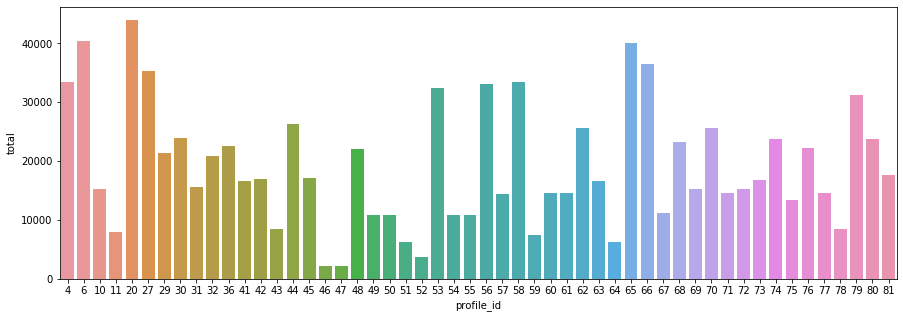

In [8]:
plt.figure(figsize=(15,5))
count = pd.DataFrame(df[['profile_id']].groupby('profile_id').size()).reset_index()
count.columns = ["profile_id", "total"]
sns.barplot(count.profile_id,count.total)
plt.show()

In [9]:
count

,profile_id,total
0,4,33423
1,6,40387
2,10,15255
3,11,7886
4,20,43970
5,27,35360
6,29,21357
7,30,23862
8,31,15586
9,32,20959


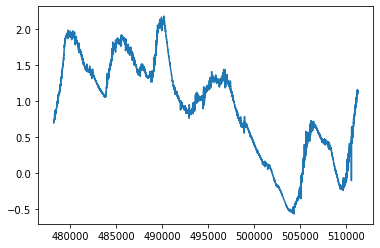

In [10]:
plt.plot(df[df.profile_id==56].pm)
plt.show()

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
class LSTM_Net(nn.Module):
    def __init__(self, features, hidden, h1, h2, out):
        super(LSTM_Net, self).__init__()
        self.h1 = h1
        self.h2 = h2

        self.hidden_size = hidden
        self.features = features

        self.lstm = nn.LSTM(self.features, self.hidden_size, 1, #feature_size, hidden_size, num_layer
                            batch_first = True) 
        self.fc1 = nn.Linear(self.hidden_size, 
                                h1)
        self.out = nn.Linear(h1, out)

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            self.out = nn.Linear(h2, out)
        
        #we do it stateless so there is no need for the hidden_state
        #self.hidden = None #torch.randn(1, ??, self.hidden) #num_layer, batch, hidden_size

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x, _ =  self.lstm(x)
        x = F.tanh(x[:,-1].view(batch_size, -1))
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7]

In [0]:
def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out), FEATURES + TARGET]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
df_train[0]

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,0.677737,0.076232,0.504645,0.154203,0.005085,0.992717,0.494864,0.019217,0.000327,-0.000299,-0.001104
1,0.676080,0.076582,0.505085,0.154250,0.005084,0.992703,0.494868,0.019154,0.000433,-0.000006,-0.001018
2,0.675073,0.076665,0.505875,0.153118,0.005085,0.992688,0.494870,0.019108,0.000566,0.000173,-0.000956
3,0.675242,0.076644,0.506112,0.153110,0.005084,0.993477,0.494689,0.019294,0.000582,0.000386,-0.001018
4,0.675840,0.076642,0.506495,0.152764,0.005085,0.993236,0.494744,0.019247,0.000543,0.000464,-0.001128
...,...,...,...,...,...,...,...,...,...,...,...
33418,0.766887,0.083580,0.501501,0.315405,0.087996,0.992612,0.494884,0.108473,0.020009,0.018006,0.008830
33419,0.767634,0.083778,0.501554,0.315412,0.087991,0.992622,0.494887,0.108463,0.019999,0.018006,0.008821
33420,0.769181,0.084036,0.501460,0.315370,0.087991,0.992617,0.494885,0.108287,0.020007,0.018006,0.009058
33421,0.769674,0.084426,0.501442,0.315271,0.087996,0.992612,0.494884,0.108194,0.019990,0.018006,0.008984


In [0]:
parameters = [sherpa.Discrete('lstm_hidden',[40,140]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.0005,0.005]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back = 60
best_score = 99999

for trial in study:
    lstm = LSTM_Net(features=8, hidden=int(trial.parameters["lstm_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=1).to(device)

    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)

        inpt = np.array(X_train).reshape(-1, look_back, 8)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        
        progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),3)))
        

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 8)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_lstm")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_LSTM.csv")

In [0]:
best_model = torch.load(path + "models/best_model_lstm")
results = pd.read_csv(path + "results/AutoML_LSTM.csv")
results = results[results["Status"]=="COMPLETED"]

In [0]:
results

,Unnamed: 0,Trial-ID,Status,Iteration,batch_size,hidden_unit1,hidden_unit2,lr,lstm_hidden,Objective
1,1,1,COMPLETED,1,2048.0,56.0,28.0,0.003868,70.0,0.000012
3,3,2,COMPLETED,1,1024.0,54.0,3.0,0.004934,57.0,0.000231
5,5,3,COMPLETED,1,512.0,27.0,0.0,0.004342,117.0,0.000004
7,7,4,COMPLETED,1,1024.0,28.0,40.0,0.002932,85.0,0.000015
9,9,5,COMPLETED,1,2048.0,18.0,25.0,0.001691,52.0,0.000101
...,...,...,...,...,...,...,...,...,...,...
191,191,96,COMPLETED,1,512.0,31.0,16.0,0.003700,45.0,0.000113
193,193,97,COMPLETED,1,512.0,36.0,54.0,0.000996,56.0,0.000007
195,195,98,COMPLETED,1,512.0,62.0,49.0,0.003991,75.0,0.000003
197,197,99,COMPLETED,1,2048.0,31.0,51.0,0.002966,92.0,0.000023


In [0]:
results[results.Objective==np.min(results.Objective)]

,Unnamed: 0,Trial-ID,Status,Iteration,batch_size,hidden_unit1,hidden_unit2,lr,lstm_hidden,Objective
103,103,52,COMPLETED,1,512.0,28.0,39.0,0.004536,84.0,0.000002


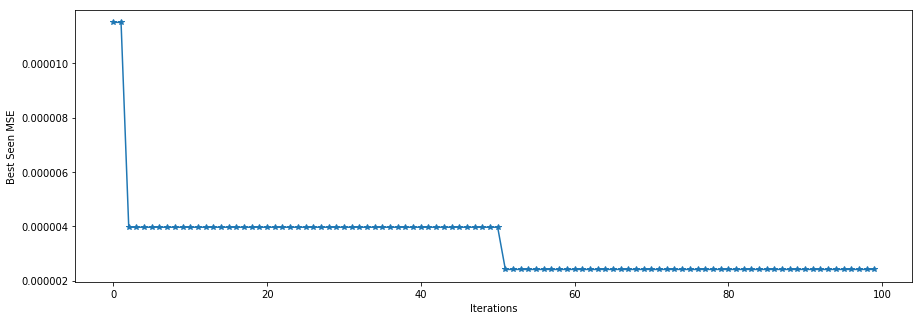

In [0]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)


batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break
    inpt = np.array(X_test).reshape(-1, look_back, 8)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

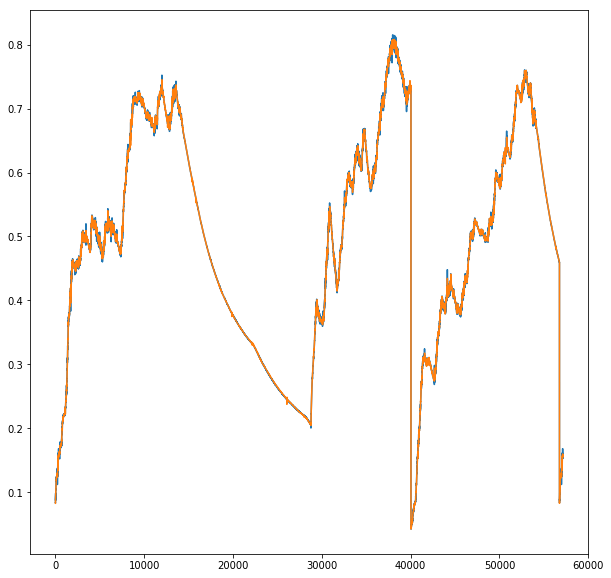

In [0]:
y_test = np.array(y_test).reshape(-1)
plt.figure(figsize=(10,10))
plt.plot(y_test[:])
plt.plot(y_pred_all[:])

plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

0.00278195590558353

# New Loss

In [0]:
def new_loss(w):
    def high_low_loss(output, target):
        return torch.mean(w*F.relu(output - target)**2 + (1-w)*F.relu(target - output)**2)
    
    return high_low_loss

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

In [0]:
parameters = [sherpa.Discrete('lstm_hidden',[40,140]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.0005,0.005]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [24]:
look_back = 60
best_score = 99999

for trial in study:
    lstm = LSTM_Net(features=11, hidden=int(trial.parameters["lstm_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=4).to(device)

    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)

        inpt = np.array(X_train).reshape(-1, look_back, 11)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        
        #progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),3)))
        

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 11)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    #score = np.mean((y_test - y_pred_all)**2) #MSE
    score = np.mean(criterion(torch.tensor(y_pred_all), 
                              torch.tensor(y_test)).item())
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_lstm_new_loss")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_LSTM_new_loss.csv")

New Challanger with MSE on val: 6.34839935142555e-05 and confs: {'lstm_hidden': 47, 'hidden_unit1': 20, 'hidden_unit2': 19, 'lr': 0.004839631935078314, 'batch_size': 1024}
New Challanger with MSE on val: 3.793524576091992e-05 and confs: {'lstm_hidden': 88, 'hidden_unit1': 23, 'hidden_unit2': 0, 'lr': 0.0006366874989484619, 'batch_size': 512}
New Challanger with MSE on val: 2.0526688322450052e-05 and confs: {'lstm_hidden': 108, 'hidden_unit1': 58, 'hidden_unit2': 41, 'lr': 0.004168414029511609, 'batch_size': 512}
New Challanger with MSE on val: 2.0131830851480153e-05 and confs: {'lstm_hidden': 135.0, 'hidden_unit1': 20.0, 'hidden_unit2': 61.0, 'lr': 0.005, 'batch_size': 512.0}
New Challanger with MSE on val: 1.9663979966869765e-05 and confs: {'lstm_hidden': 139.0, 'hidden_unit1': 40.0, 'hidden_unit2': 58.0, 'lr': 0.005, 'batch_size': 512.0}
New Challanger with MSE on val: 1.7224101946886425e-05 and confs: {'lstm_hidden': 40.0, 'hidden_unit1': 64.0, 'hidden_unit2': 12.0, 'lr': 0.005, 'ba

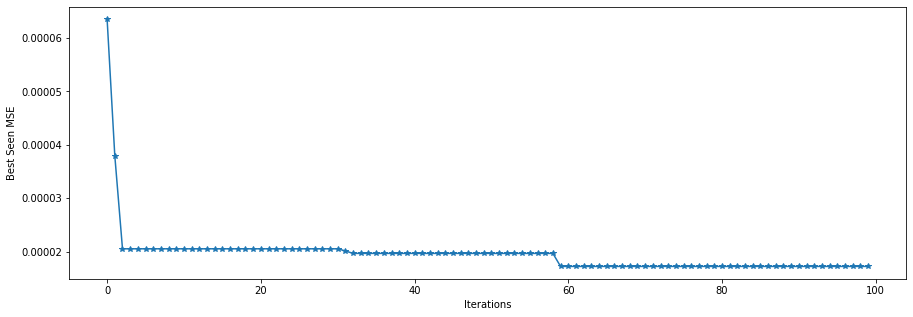

In [25]:
best_model = torch.load(path + "models/best_model_lstm_new_loss")
results = pd.read_csv(path + "results/AutoML_LSTM_new_loss.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)
batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break
    inpt = np.array(X_test).reshape(-1, look_back, 11)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_pred_all = y_pred_all.reshape(-1,4)
y_test = np.array(y_test).reshape(-1,4)

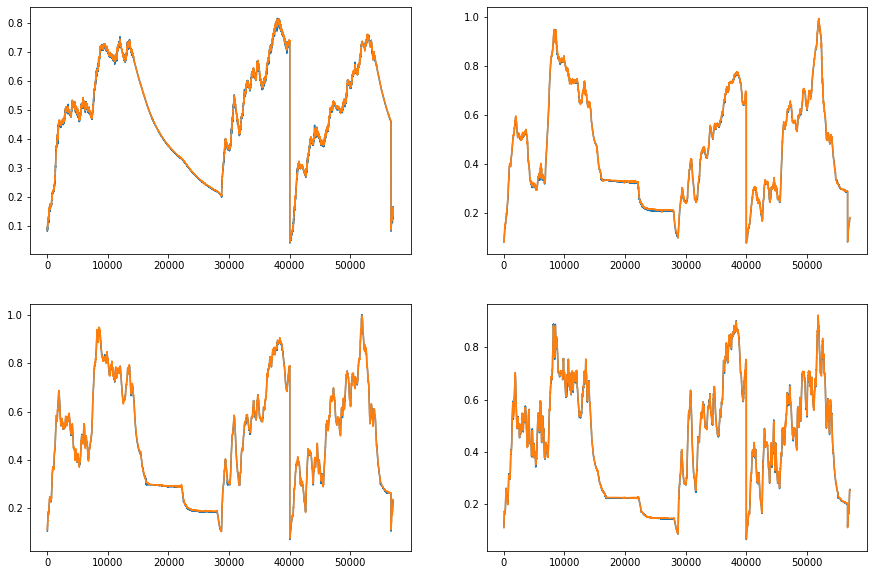

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(222)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(223)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])

plt.subplot(224)
plt.plot(y_test[:,3])
plt.plot(y_pred_all[:,3])
plt.show()

In [28]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

0.008588503453218559

# Stator Variables

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque','pm'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7,8,9]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Discrete('lstm_hidden',[40,140]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.0005,0.005]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back = 60
best_score = 99999

for trial in study:
    lstm = LSTM_Net(features=10, hidden=int(trial.parameters["lstm_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=3).to(device)

    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)

        inpt = np.array(X_train).reshape(-1, look_back, 10)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(batch_size,-1), y_batch.view(batch_size,-1))

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        
        progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),3)))
        

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 10)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_lstm_stator")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_LSTM_stator.csv")

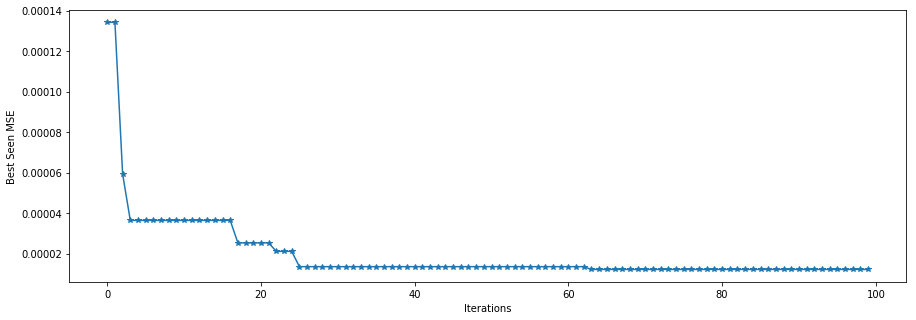

In [0]:
best_model = torch.load(path + "models/best_model_lstm_stator")
results = pd.read_csv(path + "results/AutoML_LSTM_stator.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)
batch_size = 510

y_test = []
#y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back, 10)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)
    if x==0:
        y_pred_all = y_pred.cpu().detach().numpy()
    else:
        y_pred_all = np.concatenate((y_pred_all,y_pred.cpu().detach().numpy()))

y_test = np.array(y_test).reshape(-1,3)

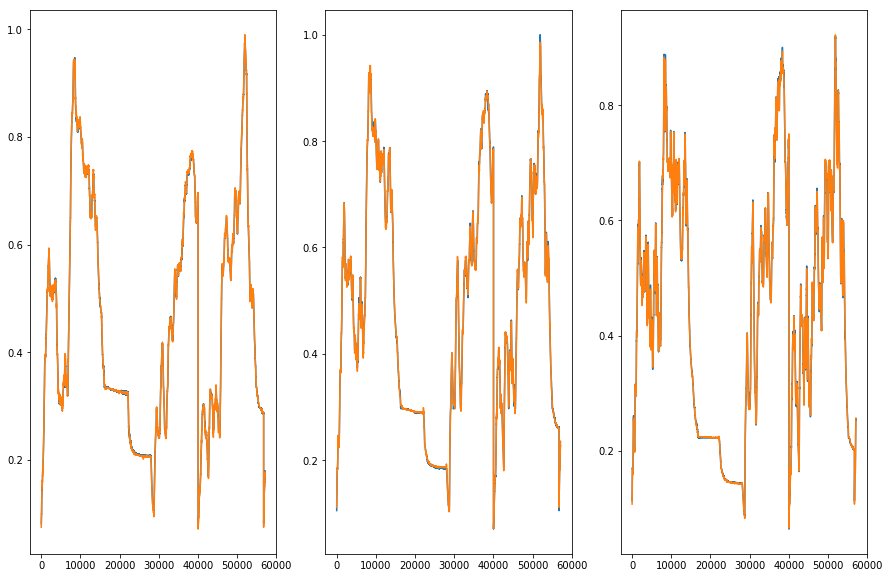

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(131)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(132)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(133)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])
plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test))) #MAPE

0.006537875819265328